Решение неоднородной двумерной краевой задачи теплопроводности с однородными к.у. Дирихле. Подобрано самостоятельно

$
\begin{cases}
    u_t = \alpha (u_{xx} + u_{yy}) + f(x, y, t), & 0 < x < 1, & 0 < y < 1, \\
    u = 0, & x = 0, & \\
    u = 0, & x = 1, & \\
    u = 0, & y = 0, & \\
    u = 0, & y = 1, & \\
    u = u_{3,4} + 0{,}5 u_{8, 6}, & t = 0, &
\end{cases}
$

где
- $\alpha = 0{,}005$ — положительное число,
- $c = 1{,}0$ — параметр, вещественное число,
- $u_{n,p}(x, y) = \sin(n \pi x) \sin(p \pi y)$,
- $f(x, y, t) = c \left[ 13 \alpha \pi^2 + (5 - 13 \alpha \pi^2) e^{-5t} \right] u_{2,3}$.

Аналитическое решение:

$
u = u_{3,4} \cdot e^{-25 \alpha \pi^2 t} + u_{8,6} \cdot 0{,}5 e^{-100 \alpha \pi^2 t} + u_{2,3} \cdot c \left( 1 - e^{-5 t} \right)
$

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/NN_pytorch_BVP
%ls -l

/content/drive/MyDrive/Colab Notebooks/NN_pytorch_BVP
total 24
drwx------ 2 root root 4096 Feb 14 09:11 data/
drwx------ 3 root root 4096 Feb 14 09:11 NN_pytorch_BVP/
drwx------ 2 root root 4096 Feb 14 09:11 notebooks/
drwx------ 2 root root 4096 Feb 14 10:49 runs/
drwx------ 2 root root 4096 Feb 14 09:11 scripts/
drwx------ 3 root root 4096 Feb 14 09:11 tests/


In [3]:
import time
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, replace, asdict, field, fields
import math
from contextlib import nullcontext
import json

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
from tqdm import trange

from NN_pytorch_BVP.pinn import MultilayerPerceptronWithFFE, compute_grad_theta_norm, sample_points_3D

mpl.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 1.0,   # optional
})
            
# Для аккуратного масштабирования пределов оси Y во время рендера анимации обучения
def smooth_autoscale_y_hysteresis(ax, y, pad=0.05, alpha_shrink=0.08):
    """
    Smoothly adjust the y-axis limits to follow streaming data.

    Each call computes target y-limits from the current data `y` (with a small
    padding), then updates the axes limits with hysteresis:
      - expand immediately if the new data exceeds the current limits (avoid clipping)
      - shrink gradually toward tighter limits (reduce jitter/"breathing")

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes whose y-limits will be updated.
    y : array-like
        Current y-data (list/NumPy array/torch tensor converted to array).
    pad : float, default=0.05
        Fractional padding added above and below the data range.
    alpha_shrink : float, default=0.08
        Smoothing factor for shrinking (0 < alpha <= 1). Smaller = smoother/slower.
    """
    y = np.asarray(y)
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if ymin == ymax:
        ymin -= 1.0
        ymax += 1.0

    yr = ymax - ymin
    ymin_t = ymin - pad * yr
    ymax_t = ymax + pad * yr

    cur_ymin, cur_ymax = ax.get_ylim()

    # Expand immediately if needed
    if ymin_t < cur_ymin:
        cur_ymin = ymin_t
    else:  # shrink slowly
        cur_ymin = (1 - alpha_shrink) * cur_ymin + alpha_shrink * ymin_t

    if ymax_t > cur_ymax:
        cur_ymax = ymax_t
    else:
        cur_ymax = (1 - alpha_shrink) * cur_ymax + alpha_shrink * ymax_t

    ax.set_ylim(cur_ymin, cur_ymax)

torch.manual_seed(2008)
 
@dataclass(frozen=True)
class PINNConfig:
    # Problem parameters
    xlims: list[float] = field(default_factory=lambda: [0.0, 1.0])    # x_min, x_max
    ylims: list[float] = field(default_factory=lambda: [0.0, 1.0])    # y_min, y_max
    tlims: list[float] = field(default_factory=lambda: [0.0, 3.0])    # t_min, t_max

    # Model parameters
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    init_scheme: str = "glorot_normal"
    layers: list[int] = field(default_factory=lambda: [3, 256, 256, 1]) 

    # Training parameters
    results_folder: Path = Path.cwd() / 'runs' / "heat_equation_2d_custom1"
    n_epochs: int = 5000
    n_r: int = 80000
    n_ic: int = field(init=False)
    n_bc_x: int = field(init=False)
    n_bc_y: int = field(init=False)
    n_batches: int = 10    # number of batches per epoch
    batch_size_r: int = field(init=False)
    batch_size_ic: int = field(init=False)
    batch_size_bc_x: int = field(init=False)
    batch_size_bc_y: int = field(init=False)
    lambda_r: float = 1.0
    lambda_ic: float = 1.0
    lambda_bc: float = 1.0
    lr: float = 1e-3    # initial learning rate
    use_static_training_set: bool = False
    logging_freq: int = 1    # log metrics once every N gradient descent steps

    # Checkpointing
    use_checkpointing: bool = False
    checkpointing_freq: int = 2000    # save model and metrics to the results_folder once every N gradient descent steps

    # Fourier Feature embedding
    use_FFE: bool = False
    FFE_m: int = 100
    FFE_sigma: float = 1.0
    FFE_keep_dims: None | list[int] = None    # Indices of input dimensions to be passed through unchanged

    # Grad norm weighting
    use_grad_norm_weighting: bool = False
    grad_norm_weighting_alpha: float = 0.9
    grad_norm_weighting_freq: int = 200    # update lambdas once every N gradient descent steps

    # Causal weighting
    use_causal_weighting_scheme: bool = False
    causal_m: int = 10
    causal_eps: float = 100.0
    W_logging_freq: int = 100    # log temporal weights and L_t once every N gradient descent steps

    # Video parameters
    render_video: bool = False
    video_fps: int = 30
    video_dpi: int = 100
    video_render_freq: int = 100    # render a frame once every N gradient descent steps

    def __str__(self):
        res = []
        for field in fields(self):
            res.append(f"{field.name}: {getattr(self, field.name)}")
        return "\n".join(res)
    
    def __post_init__(self):
        xlims = self.xlims[:]
        ylims = self.ylims[:]
        tlims = self.tlims[:]

        Lx = xlims[1] - xlims[0]
        Ly = ylims[1] - ylims[0]
        T = tlims[1] - tlims[0]
        tmp = (self.n_r/(Lx*Ly*T))**(2.0/3.0)

        n_ic = math.ceil( Lx*Lx*tmp )
        n_bc_x = max(
            2, 
            2 * math.ceil( Ly*T*tmp ) 
        )
        n_bc_y = max(
            2, 
            2 * math.ceil( Lx*T*tmp ) 
        )

        object.__setattr__(self, "n_ic", n_ic)
        object.__setattr__(self, "n_bc_x", n_bc_x)
        object.__setattr__(self, "n_bc_y", n_bc_y)

        batch_size_r = self.n_r / self.n_batches
        batch_size_ic = n_ic / self.n_batches
        if batch_size_ic < 1:
            raise ValueError(f"batch_size_ic turned out to be less than 1 ({batch_size_ic:.1f})." + 
                " Increase n_r or decrease n_batches!")
        batch_size_bc_x = n_bc_x / self.n_batches
        if batch_size_bc_x < 2:
            raise ValueError(f"batch_size_bc_x turned out to be less than 2 ({batch_size_bc_x:.1f})." +
                " Increase n_r or decrease n_batches!")
        batch_size_bc_y = n_bc_y / self.n_batches
        if batch_size_bc_y < 2:
            raise ValueError(f"batch_size_bc_y turned out to be less than 2 ({batch_size_bc_y:.1f})." +
                " Increase n_r or decrease n_batches!")
        object.__setattr__(self, "batch_size_r", math.ceil(batch_size_r))
        object.__setattr__(self, "batch_size_ic", math.ceil(batch_size_ic))
        object.__setattr__(self, "batch_size_bc_x", math.ceil(batch_size_bc_x))
        object.__setattr__(self, "batch_size_bc_y", math.ceil(batch_size_bc_y))

class Trainer:
    def __init__(self, model, optimizer, scheduler, cfg: PINNConfig):
        self.model = model.to(cfg.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.cfg = cfg
        self.results_folder = self.cfg.results_folder
        self.results_folder.mkdir(parents=True, exist_ok=True)

        if cfg.use_checkpointing:
            (self.results_folder / "model").mkdir(parents=True, exist_ok=True)
            (self.results_folder / "metrics").mkdir(parents=True, exist_ok=True)

        # Save cfg dataclass object to the results folder as json
        def to_jsonable(x):
            if isinstance(x, Path):
                return str(x)
            if isinstance(x, torch.device):
                return str(x)
            return x
        data = {k: to_jsonable(v) for k, v in asdict(cfg).items()}
        del data["results_folder"]
        (self.results_folder / "config.json").write_text(json.dumps(data, indent=2))

        self.xlims = list(cfg.xlims)
        self.ylims = list(cfg.ylims)
        self.tlims = list(cfg.tlims)
        self.device = cfg.device
        self.use_static_training_set = cfg.use_static_training_set

        self.grad_norm_weighting_alpha = cfg.grad_norm_weighting_alpha
        self.use_causal_weighting_scheme = cfg.use_causal_weighting_scheme
        self.causal_m = cfg.causal_m
        self.causal_eps = cfg.causal_eps

        # Boundary value problem parameters
        self.alpha = 0.005
        self.c = 1.0

    def u_np(self, n: int, p: int, txy):
        return torch.sin(n * torch.pi * txy[:, 1:2]) * torch.sin(p * torch.pi * txy[:, 2:3])

    def u_exact(self, txy):
        pi_sq = torch.pi * torch.pi
        return torch.exp(-25.0 * self.alpha * pi_sq * txy[:, 0:1] ) * self.u_np(3, 4, txy) + \
            0.5 * torch.exp(-100 * self.alpha * pi_sq * txy[:, 0:1]) * self.u_np(8, 6, txy) + \
            self.c * (1.0 - torch.exp(-5.0 * txy[:, 0:1])) * self.u_np(2, 3, txy)

    def sample_points(self, n_r: int, n_ic: int, n_bc_x: int, n_bc_y: int):
        x_min, x_max = self.xlims
        y_min, y_max = self.ylims
        t_min, t_max = self.tlims

        txy_r = sample_points_3D(
            [t_min, x_min, y_min, t_max, x_max, y_max], 
            n_r, scheme="uniform", device=self.device
        )
        txy_r.requires_grad_(True)

        txy_ic = sample_points_3D(
            [t_min, x_min, y_min, t_min, x_max, y_max], 
            n_ic, scheme="uniform", device=self.device
        )
        txy_ic.requires_grad_(True)

        txy_bc_xmin = sample_points_3D(
            [t_min, x_min, y_min, t_max, x_min, y_max], 
            n_bc_x // 2, scheme="uniform", device=self.device
        )
        txy_bc_xmin.requires_grad_(True)
        txy_bc_xmax = sample_points_3D(
            [t_min, x_max, y_min, t_max, x_max, y_max], 
            n_bc_x // 2, scheme="uniform", device=self.device
        )
        txy_bc_xmax.requires_grad_(True)
        txy_bc_ymin = sample_points_3D(
            [t_min, x_min, y_min, t_max, x_max, y_min], 
            n_bc_y // 2, scheme="uniform", device=self.device
        )
        txy_bc_ymin.requires_grad_(True)
        txy_bc_ymax = sample_points_3D(
            [t_min, x_min, y_max, t_max, x_max, y_max], 
            n_bc_y // 2, scheme="uniform", device=self.device
        )
        txy_bc_ymax.requires_grad_(True)

        return txy_r, txy_ic, txy_bc_xmin, txy_bc_xmax, txy_bc_ymin, txy_bc_ymax

    def compute_loss_terms(self, txy_r, txy_ic, txy_bc_xmin, txy_bc_xmax, txy_bc_ymin, txy_bc_ymax,
            lambda_r=1.0, lambda_ic=1.0, lambda_bc=1.0, update_lambdas=False):
        model = self.model
        optimizer = self.optimizer
        use_causal_weighting_scheme = self.use_causal_weighting_scheme
        causal_m = self.causal_m
        causal_eps = self.causal_eps
        t_min, t_max = self.tlims
        
        u_r = model(txy_r)
        u_ic = model(txy_ic)
        u_bc_xmin = model(txy_bc_xmin)
        u_bc_xmax = model(txy_bc_xmax)
        u_bc_ymin = model(txy_bc_ymin)
        u_bc_ymax = model(txy_bc_ymax)

        # Compute loss_r
        tmp = torch.autograd.grad(u_r, txy_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
        u_t = tmp[:, 0:1]
        u_x = tmp[:, 1:2]
        u_y = tmp[:, 2:3]
        u_xx = torch.autograd.grad(u_x, txy_r, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
        u_yy = torch.autograd.grad(u_y, txy_r, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 2:3]
        res_r = u_t - self.alpha * (u_xx + u_yy) - \
            self.c * ( 13.0 * self.alpha * torch.pi**2 + (5.0 - 13.0 * self.alpha * torch.pi**2) * 
            torch.exp(-5.0 * txy_r[:, 0:1]) ) * self.u_np(2, 3, txy_r)
        if use_causal_weighting_scheme:
            t_flat = txy_r[:, 0].detach().squeeze(-1)
            L_t = torch.zeros(causal_m, device=self.device)
            h = (t_max - t_min) / causal_m
            for i in range(causal_m):
                mask = ((t_min + i * h < t_flat) & (t_flat <= t_min + (i + 1) * h))
                if mask.any():
                    L_t[i] = torch.mean(res_r[mask]**2)
                else:
                    L_t[i] = 0.0
            M = torch.tril(torch.ones(causal_m, causal_m, device=self.device), diagonal=-1)
            W = torch.exp(-causal_eps * (M @ L_t)).detach()
            loss_r = (W * L_t).mean()
        else:
            loss_r = torch.mean(res_r**2)
        if update_lambdas:
            optimizer.zero_grad()
            loss_r.backward(retain_graph=True)
            grad_loss_r_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_ic
        res_ic = u_ic - self.u_np(3, 4, txy_ic) - 0.5 * self.u_np(8, 6, txy_ic)
        loss_ic = torch.mean(res_ic**2)
        if update_lambdas:
            optimizer.zero_grad()
            loss_ic.backward(retain_graph=True)
            grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_bc
        res_bc = torch.cat([u_bc_xmin, u_bc_xmax, u_bc_ymin, u_bc_ymax], dim=0)
        loss_bc = torch.mean( res_bc**2 )
        if update_lambdas:
            optimizer.zero_grad()
            loss_bc.backward(retain_graph=True)
            grad_loss_bc_theta_norm = compute_grad_theta_norm(model)

        # Compute new lambdas if needed
        if update_lambdas:
            tmp = grad_loss_r_theta_norm + grad_loss_ic_theta_norm + grad_loss_bc_theta_norm
            alpha = self.grad_norm_weighting_alpha
            lambda_r = alpha*lambda_r + (1.0 - alpha) * tmp / grad_loss_r_theta_norm
            lambda_ic = alpha*lambda_ic + (1.0 - alpha) * tmp / grad_loss_ic_theta_norm
            lambda_bc = alpha*lambda_bc + (1.0 - alpha) * tmp / grad_loss_bc_theta_norm

        loss = lambda_r * loss_r + lambda_ic * loss_ic + lambda_bc * loss_bc

        return (loss, loss_r, loss_ic, loss_bc, lambda_r, lambda_ic, lambda_bc,
                res_r, res_ic, res_bc,
                W if use_causal_weighting_scheme else None, L_t if use_causal_weighting_scheme else None)

    def train(self):
        n_epochs = self.cfg.n_epochs
        n_batches = self.cfg.n_batches
        batch_size_r = self.cfg.batch_size_r
        batch_size_ic = self.cfg.batch_size_ic
        batch_size_bc_x = self.cfg.batch_size_bc_x
        batch_size_bc_y = self.cfg.batch_size_bc_y

        use_grad_norm_weighting = self.cfg.use_grad_norm_weighting
        grad_norm_weighting_freq = self.cfg.grad_norm_weighting_freq
        use_causal = self.use_causal_weighting_scheme
        optimizer = self.optimizer
        scheduler = self.scheduler
        lambda_r = self.cfg.lambda_r
        lambda_ic = self.cfg.lambda_ic
        lambda_bc = self.cfg.lambda_bc
        use_static_training_set = self.use_static_training_set
        n_r = self.cfg.n_r
        n_ic = self.cfg.n_ic
        n_bc_x = self.cfg.n_bc_x
        n_bc_y = self.cfg.n_bc_y
        device = self.device
        W_logging_freq = self.cfg.W_logging_freq
        logging_freq = self.cfg.logging_freq
        t_min, t_max = self.tlims
        x_min, x_max = self.xlims
        y_min, y_max = self.ylims
        causal_m = self.cfg.causal_m
        render_video = self.cfg.render_video
        model = self.model
        use_checkpointing = self.cfg.use_checkpointing
        checkpointing_freq = self.cfg.checkpointing_freq
        results_folder = self.results_folder
        n_iters = n_epochs * n_batches

        # Для логирования
        n_log = n_iters // logging_freq
        n_wlog = n_iters // W_logging_freq
        metrics = {
            "step": torch.arange(0, n_iters, logging_freq),
            "loss": torch.zeros(n_log),
            "loss_r": torch.zeros(n_log),
            "loss_ic": torch.zeros(n_log),
            "loss_bc": torch.zeros(n_log),
            "err_l2": torch.zeros(n_log),
            "rel_err_l2": torch.zeros(n_log),
            "lambda_r": torch.zeros(n_log),
            "lambda_ic": torch.zeros(n_log),
            "lambda_bc": torch.zeros(n_log),
            "lr": torch.zeros(n_log),

            "W_step": torch.arange(0, n_iters, W_logging_freq),
            "W": [None] * n_wlog,
            "L_t": [None] * n_wlog
        }

        txy = torch.cartesian_prod(
            torch.linspace(t_min, t_max, 50, device=device),
            torch.linspace(x_min, x_max, 50, device=device),
            torch.linspace(y_min, y_max, 50, device=device)
        )
        u_exact_arr = self.u_exact(txy).detach().cpu()
        u_exact_arr_l2 = torch.norm(u_exact_arr, p=2).item()

        # Video
        video_path = results_folder / ("training_animation_" + ".mp4")
        video_render_freq = self.cfg.video_render_freq

        ### ДЛЯ АНИМАЦИИ ПРОЦЕССА ОБУЧЕНИЯ
        if render_video:
            writer = anim.FFMpegWriter(
                fps=self.cfg.video_fps, 
                codec='libx264', 
                extra_args=['-pix_fmt', 'yuv420p', '-preset', 'ultrafast', "-threads", "0"]
            )
            w, h = plt.rcParams['figure.figsize']
            w *= 0.6
            h *= 0.6

            # model(t)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, 1*h), constrained_layout=True)
        
            # Temporal weights
            (line1, ) = ax1.plot(torch.arange(causal_m), torch.zeros(causal_m))
            ax1.set(title="Temporal weights $w_i$", xlabel="$i$", ylabel="$w_i$", ylim=[0, 1.1])

            # L_t
            (line2, ) = ax2.semilogy(torch.arange(causal_m), torch.ones(causal_m))
            ax2.set(title="$\\mathcal{L}_{r}^{i}$", xlabel="$i$", ylabel="$\\mathcal{L}_{r}^{i}$", ylim=[1e-5, 1])

        pbar = trange(n_iters, desc="Training model")
        with writer.saving(fig, video_path, dpi=self.cfg.video_dpi) if render_video else nullcontext():
            for iter in pbar:
                i_batch = iter % n_batches    # batch index inside the current epoch
                if i_batch == 0 or (not use_static_training_set):
                    txy_r, txy_ic, txy_bc_xmin, txy_bc_xmax, txy_bc_ymin, txy_bc_ymax = self.sample_points(n_r, n_ic, n_bc_x, n_bc_y)
                if use_static_training_set:    # re-leaf tensors
                    txy_r = txy_r.detach().requires_grad_(True)
                    txy_ic = txy_ic.detach().requires_grad_(True)
                    txy_bc_xmin = txy_bc_xmin.detach().requires_grad_(True)
                    txy_bc_xmax = txy_bc_xmax.detach().requires_grad_(True)
                    txy_bc_ymin = txy_bc_ymin.detach().requires_grad_(True)
                    txy_bc_ymax = txy_bc_ymax.detach().requires_grad_(True)
                loss, loss_r, loss_ic, loss_bc, lambda_r, lambda_ic, lambda_bc, res_r, res_ic, res_bc, W, L_t = self.compute_loss_terms(
                    txy_r[i_batch*batch_size_r:(i_batch+1)*batch_size_r], 
                    txy_ic[i_batch*batch_size_ic:(i_batch+1)*batch_size_ic], 
                    txy_bc_xmin[i_batch*(batch_size_bc_x//2):(i_batch+1)*(batch_size_bc_x//2)], 
                    txy_bc_xmax[i_batch*(batch_size_bc_x//2):(i_batch+1)*(batch_size_bc_x//2)], 
                    txy_bc_ymin[i_batch*(batch_size_bc_y//2):(i_batch+1)*(batch_size_bc_y//2)], 
                    txy_bc_ymax[i_batch*(batch_size_bc_y//2):(i_batch+1)*(batch_size_bc_y//2)], 
                    lambda_r=lambda_r, lambda_ic=lambda_ic, lambda_bc=lambda_bc, 
                    update_lambdas = use_grad_norm_weighting and iter % grad_norm_weighting_freq == 0)

                self.optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                if use_causal and iter % W_logging_freq == 0:
                    i = iter // W_logging_freq
                    metrics["W"][i] = W.detach().cpu().numpy()
                    metrics["L_t"][i] = L_t.detach().cpu().numpy()
                
                if iter % logging_freq == 0:
                    i = iter // logging_freq
                    metrics["loss"][i] = loss.item()
                    metrics["loss_r"][i] = loss_r.item()
                    metrics["loss_ic"][i] = loss_ic.item()
                    metrics["loss_bc"][i] = loss_bc.item()
                    metrics["err_l2"][i] = torch.norm(u_exact_arr - model(txy).detach().cpu(), p=2).item()
                    metrics["rel_err_l2"][i] = metrics["err_l2"][i] / u_exact_arr_l2 * 100
                    metrics["lambda_r"][i] = lambda_r
                    metrics["lambda_ic"][i] = lambda_ic
                    metrics["lambda_bc"][i] = lambda_bc
                    metrics["lr"][i] = optimizer.param_groups[0]["lr"]

                    pbar.set_postfix({
                        'loss': metrics["loss"][i].item(),
                        "err_l2": metrics["err_l2"][i].item(),
                        "rel_err_l2": metrics["rel_err_l2"][i].item(),
                        'lambda_r': metrics["lambda_r"][i].item(),
                        'lambda_ic': metrics["lambda_ic"][i].item(),
                        'lambda_bc': metrics["lambda_bc"][i].item()
                    })

                # Рендер кадра анимации
                if render_video and iter % video_render_freq == 0:
                    if use_causal:
                        line1.set_ydata(W.detach().cpu())
                        line2.set_ydata(L_t.detach().cpu())
                    writer.grab_frame()

                if use_checkpointing and ( (iter + 1) % checkpointing_freq == 0 or (iter + 1) == n_iters ):
                    # save model
                    model_path = results_folder / "model" / ("model_epoch=" + str(iter//n_batches + 1) + 
                        "_batch=" + str(iter % n_batches + 1) + ".pth")
                    MultilayerPerceptronWithFFE.save(model, model_path)    

                    # save metrics
                    metrics_path = results_folder / "metrics" / ("metrics_epoch=" + str(iter//n_batches + 1) +
                        "_batch=" + str(iter % n_batches + 1) + ".pth")
                    torch.save(metrics, metrics_path)

        return metrics
    
    def render_metrics_plots(self, metrics: dict, show=True, save_to_disk: bool = False, fmt: str ="png",
            video_fps: int = 30, video_dpi: int = 150):
        if save_to_disk:
            plot_path = self.results_folder / "plots"
            plot_path.mkdir(parents=True, exist_ok=True)

        w, h = plt.rcParams['figure.figsize']
        t_min, t_max = self.tlims
        x_min, x_max = self.xlims
        y_min, y_max = self.ylims
        device = self.device

        def show_plot(fig, show):
            if not show:
                plt.close(fig)

        def save_fig(fig, save_path: Path, dpi: int = 300):
            if save_to_disk:
                fig.tight_layout()
                fig.savefig(save_path, dpi=dpi)
        
        # Losses
        fig, ax = plt.subplots()
        ax.set(title="Losses", xlabel="grad step")
        ax.semilogy(metrics["step"], metrics["loss"], label="loss")
        ax.semilogy(metrics["step"], metrics["loss_r"], label="loss_r")
        ax.semilogy(metrics["step"], metrics["loss_ic"], label="loss_ic")
        ax.semilogy(metrics["step"], metrics["loss_bc"], label="loss_bc")
        ax.legend()
        show_plot(fig, show)
        save_fig(fig, plot_path / ("losses" + "." + fmt))
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(2*w, 2*h))
        ax1.semilogy(metrics["step"], metrics["loss"], label="loss", color='C0')
        ax1.legend()
        ax2.semilogy(metrics["step"], metrics["loss_r"], label="loss_r", color='C1')
        ax2.legend()
        ax3.semilogy(metrics["step"], metrics["loss_ic"], label="loss_ic", color='C2')
        ax3.legend()
        ax4.semilogy(metrics["step"], metrics["loss_bc"], label="loss_bc", color='C3')
        ax4.legend()
        show_plot(fig, show)
        save_fig(fig, plot_path / ("losses_separate" + "." + fmt))

        # Error
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
        ax1.plot(metrics["step"], metrics["err_l2"])
        ax1.set(title="Error L2 norm", xlabel="grad step")
        ax2.plot(metrics["step"], metrics["rel_err_l2"])
        ax2.set(title="Relative error L2 norm", xlabel="grad step", ylabel="%")
        show_plot(fig, show)
        save_fig(fig, plot_path / ("error" + "." + fmt))

        # Lambdas
        if self.cfg.use_grad_norm_weighting:
            fig, ax = plt.subplots()
            ax.plot(metrics["step"], metrics["lambda_r"], label="lambda_r")
            ax.plot(metrics["step"], metrics["lambda_ic"], label="lambda_ic")
            ax.plot(metrics["step"], metrics["lambda_bc"], label="lambda_bc")
            ax.set_xlabel("grad step")
            ax.legend()
            show_plot(fig, show)
            save_fig(fig, plot_path / ("lambdas" + "." + fmt))

        # Temporal weights
        if self.cfg.use_causal_weighting_scheme:
            W = np.stack(metrics["W"])
            t = np.arange(W.shape[1])
            fig, ax = plt.subplots()
            pm = ax.pcolormesh(t, metrics["W_step"], W, shading='auto', cmap='binary')
            cbar = fig.colorbar(pm, ax=ax)
            ax.set(title="Temporal weights $w_i$ over training", xlabel="$i$", ylabel="gradient step")
            show_plot(fig, show)
            save_fig(fig, plot_path / ("temporal_weights" + "." + fmt))

        # L_t
        if self.cfg.use_causal_weighting_scheme:
            L_t = np.stack(metrics["L_t"])
            t = np.arange(L_t.shape[1])
            fig, ax = plt.subplots()
            pm = ax.pcolormesh(t, metrics["W_step"], L_t, shading='auto', cmap='binary',
                norm=colors.LogNorm())
            cbar = fig.colorbar(pm, ax=ax)
            ax.set(title="$\\mathcal{L}_{r}^{i}$ for gradient steps", xlabel="$i$", ylabel="grad step")
            show_plot(fig, show)
            save_fig(fig, plot_path / ("l_t" + "." + fmt))

        # Learning rate
        fig, ax = plt.subplots()
        ax.set(title="Learning rate", xlabel="grad step")
        ax.semilogy(metrics["step"], metrics["lr"])
        show_plot(fig, show)
        save_fig(fig, plot_path / ("learning_rate" + "." + fmt))

        # Model vs reference solution
        with torch.no_grad():
            model = self.model.to("cpu")
            txy = torch.cartesian_prod(
                torch.linspace(t_min, t_max, 80),
                torch.linspace(x_min, x_max, 80),
                torch.linspace(y_min, y_max, 80)
            )
            u_exact_arr = self.u_exact(txy).reshape(-1)
            u_exact_min = u_exact_arr.min()
            u_exact_max = u_exact_arr.max()
            u_model = model(txy)
            # txy = torch.cartesian_prod(
            #     torch.ones(1, device=device),
            #     torch.linspace(x_min, x_max, 80, device=device),
            #     torch.linspace(y_min, y_max, 80, device=device)
            # )
            # u_exact_arr = self.u_exact(txy).reshape(-1)
            # u_model = model(txy)

            w, h = plt.rcParams['figure.figsize']
            w *= 0.6
            h *= 0.6
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(2*w, 2*h), constrained_layout=True)
            pc1 = ax1.tripcolor(
                txy[:, 1].detach().cpu(), txy[:, 2].detach().cpu(), u_exact_arr.reshape(-1), 
                vmin=u_exact_min, vmax=u_exact_max, shading="gouraud", cmap="coolwarm")
            ax1.set(title="Exact solutions", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc1, ax=ax1)
            pc2 = ax2.tripcolor(
                txy[:, 1].detach().cpu(), txy[:, 2].detach().cpu(), u_model.reshape(-1), 
                vmin=u_exact_min, vmax=u_exact_max, shading="gouraud", cmap="coolwarm")
            ax2.set(title="Model solutions", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc2, ax=ax2)
            err_arr = torch.abs(u_model.reshape(-1) - u_exact_arr)
            pc3 = ax3.tripcolor(
                txy[:, 1].detach().cpu(), txy[:, 2].detach().cpu(), err_arr, 
                vmin=err_arr.min(), vmax=err_arr.max(), shading="gouraud", cmap="binary")
            ax3.set(title="abs(u_exact - model)", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc3, ax=ax3)
            show_plot(fig, show)

            writer = anim.FFMpegWriter(
                fps=video_fps, 
                codec='libx264', 
                extra_args=['-pix_fmt', 'yuv420p', '-preset', 'ultrafast', "-threads", "0"]
            )

            pbar = trange(int((t_max - t_min) * video_fps), desc="Render output video")
            frame_time = 1.0 / video_fps
            n_points = txy.shape[0]
            with writer.saving(fig, self.results_folder / "model_vs_exact_solution.mp4", dpi=video_dpi):
                for iter in pbar:
                    time = t_min + frame_time * iter
                    fig.suptitle(f"time = {time:10.2f}")

                    txy[:, 0] = torch.ones(n_points) * time
                    u_approx = model(txy).reshape(-1)
                    u_exact_arr = self.u_exact(txy).reshape(-1)

                    pc1.set_array(u_exact_arr)
                    pc2.set_array(u_approx)
                    pc3.set_array(torch.abs(u_exact_arr - u_approx))
                    writer.grab_frame()

Запуск обучения без каких-либо улучшений

xlims: [0.0, 1.0]
ylims: [0.0, 1.0]
tlims: [0.0, 3.0]
device: cuda
init_scheme: glorot_normal
layers: [3, 256, 256, 1]
results_folder: /content/drive/MyDrive/Colab Notebooks/NN_pytorch_BVP/runs/heat_equation_2d_custom1/baseline
n_epochs: 1000
n_r: 80000
n_ic: 893
n_bc_x: 5356
n_bc_y: 5356
n_batches: 10
batch_size_r: 8000
batch_size_ic: 90
batch_size_bc_x: 536
batch_size_bc_y: 536
lambda_r: 1.0
lambda_ic: 1.0
lambda_bc: 1.0
lr: 0.001
use_static_training_set: False
logging_freq: 200
use_checkpointing: True
checkpointing_freq: 2000
use_FFE: False
FFE_m: 100
FFE_sigma: 1.0
FFE_keep_dims: None
use_grad_norm_weighting: False
grad_norm_weighting_alpha: 0.9
grad_norm_weighting_freq: 200
use_causal_weighting_scheme: False
causal_m: 10
causal_eps: 100.0
W_logging_freq: 100
render_video: False
video_fps: 30
video_dpi: 100
video_render_freq: 100


Training model:   0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Render output video: 100%|██████████| 90/90 [05:39<00:00,  3.77s/it]


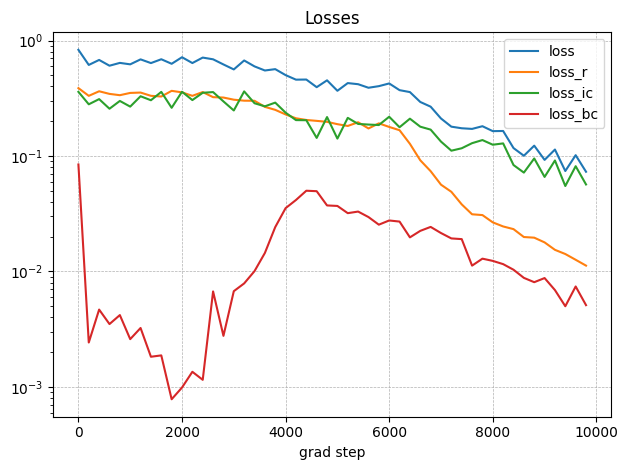

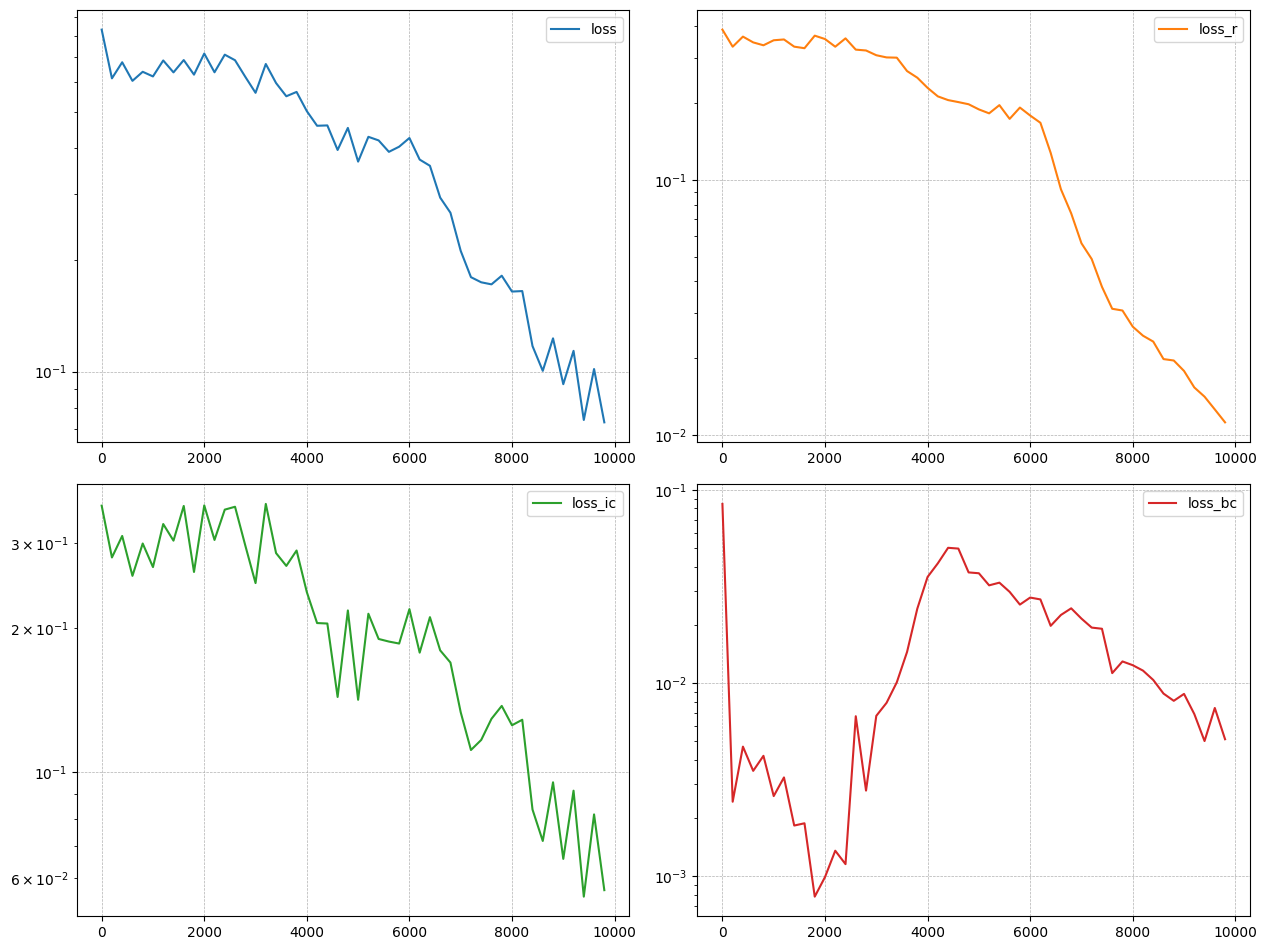

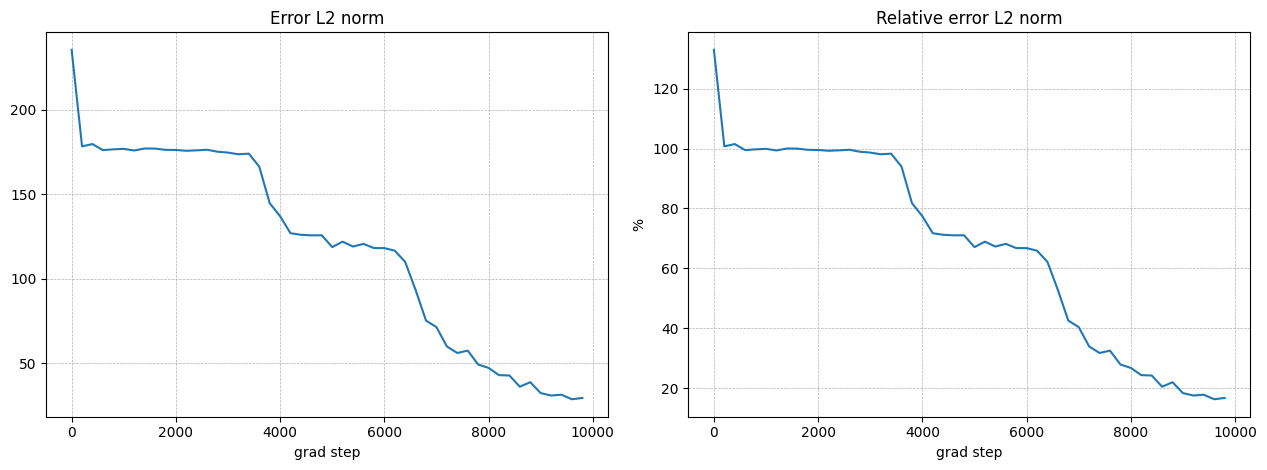

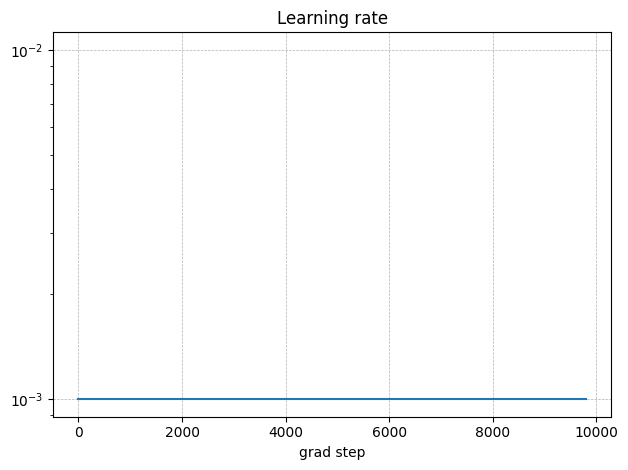

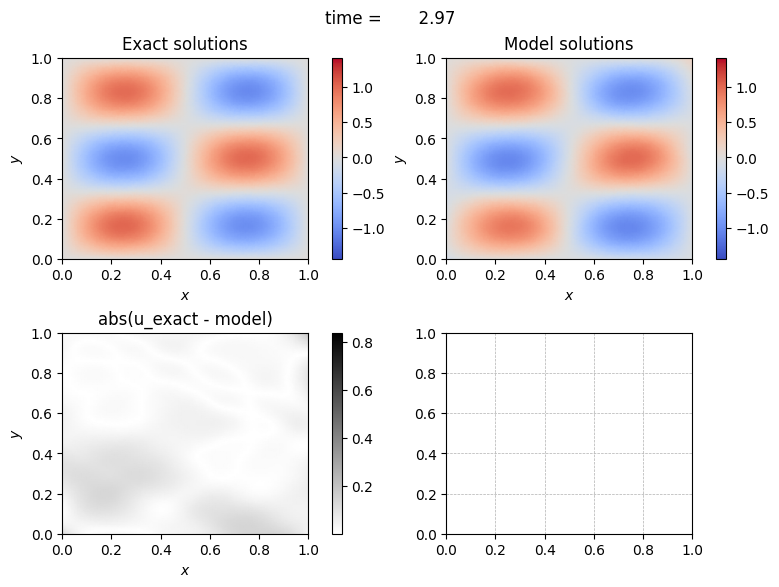

In [4]:
config_baseline = PINNConfig(
# Problem parameters
    xlims = [0.0, 1.0],    # x_min, x_max
    ylims = [0.0, 1.0],    # y_min, y_max
    tlims = [0.0, 3.0],    # t_min, t_max

    # Model parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    init_scheme = "glorot_normal",
    layers = [3, 256, 256, 1],

    # Training parameters
    results_folder = PINNConfig.results_folder / "baseline",
    n_epochs = 1000,
    n_r = 80000,
    n_batches = 10,   # number of batches per epoch
    lambda_r = 1.0,
    lambda_ic = 1.0,
    lambda_bc = 1.0,
    lr = 1e-3,    # initial learning rate
    use_static_training_set = False,
    logging_freq = 200,    # log metrics once every N gradient descent steps

    # Checkpointing
    use_checkpointing = True,
    checkpointing_freq = 2000,    # save model and metrics to the results_folder once every N gradient descent steps

    # Fourier Feature embedding
    use_FFE = False,
    #FFE_m = 10,
    #FFE_sigma = 1.0,
    #FFE_keep_dims = None,    # Indices of input dimensions to be passed through unchanged

    # Grad norm weighting
    use_grad_norm_weighting = False,
    #grad_norm_weighting_alpha = 0.9,
    #grad_norm_weighting_freq = 250,    # update lambdas once every N gradient descent steps

    # Causal weighting
    use_causal_weighting_scheme = False,
    #causal_m = 10,
    #causal_eps = 1.0,
    #W_logging_freq = 500,    # log temporal weights and L_t once every N gradient descent steps

    # Video parameters
    render_video = False,
    video_fps = 30,
    video_dpi = 100,
    video_render_freq = 100    # render a frame once every N gradient descent steps
)
model_baseline = MultilayerPerceptronWithFFE(
    config_baseline.layers, config_baseline.init_scheme,
    use_FFE=config_baseline.use_FFE, FFE_m=config_baseline.FFE_m, 
    FFE_sigma=config_baseline.FFE_sigma, FFE_keep_dims=config_baseline.FFE_keep_dims)
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=config_baseline.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_baseline = Trainer(model_baseline, optimizer, scheduler, cfg=config_baseline)
print(config_baseline)
metrics_baseline = trainer_baseline.train()

trainer_baseline.render_metrics_plots(metrics_baseline, save_to_disk=True)

Запуск обучения с полным FFE

Render output video: 100%|██████████| 90/90 [04:55<00:00,  3.29s/it]


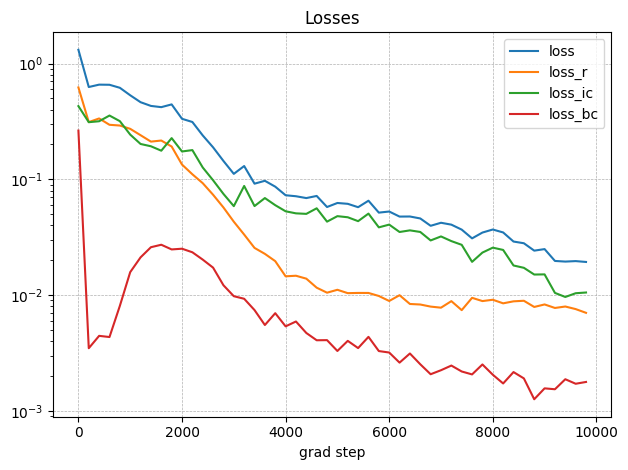

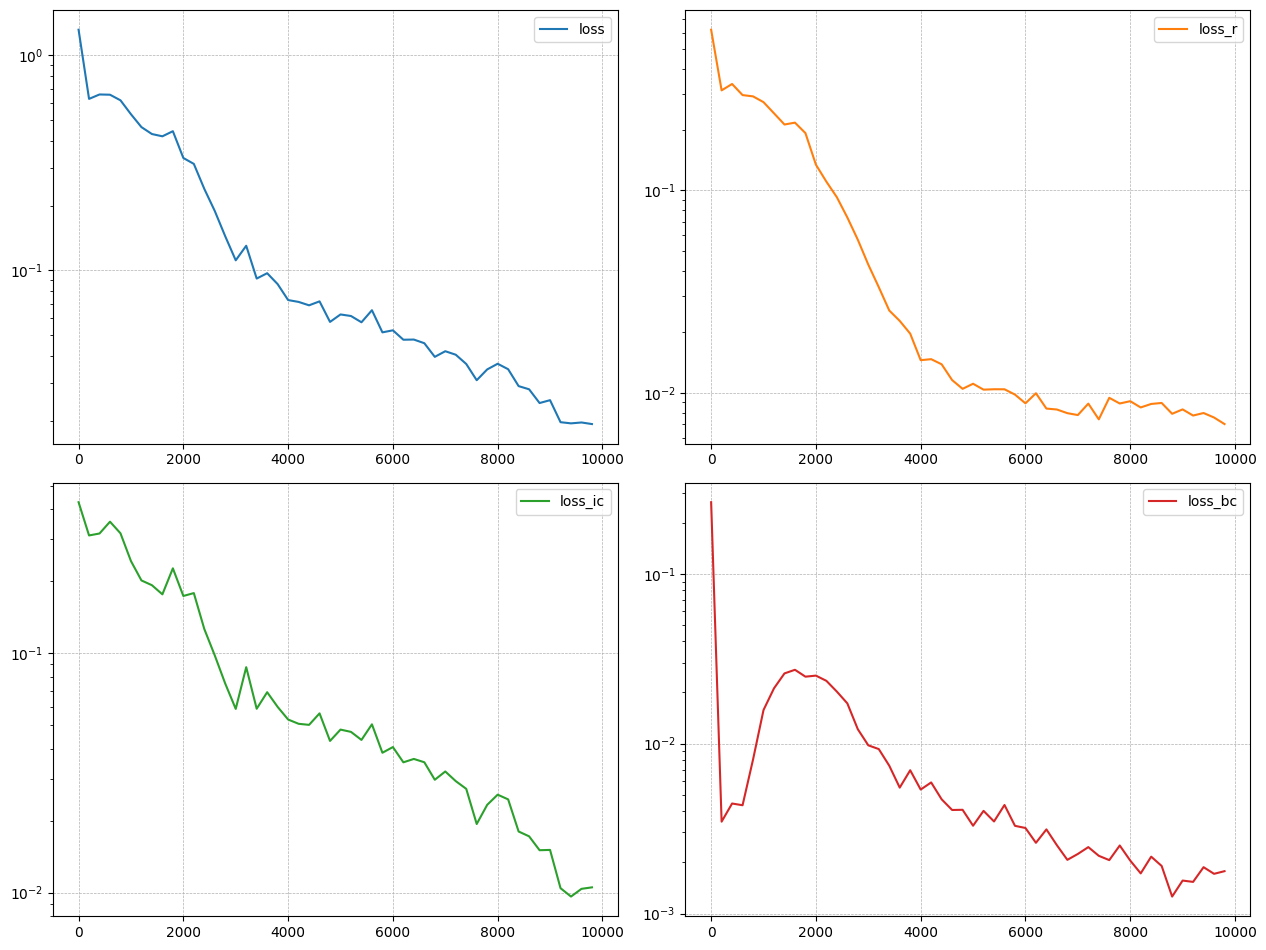

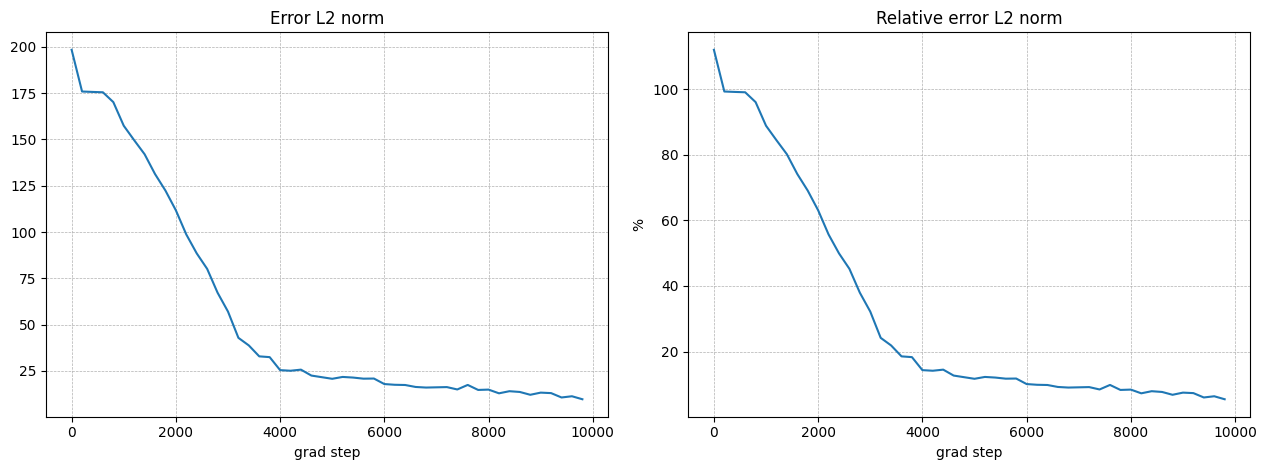

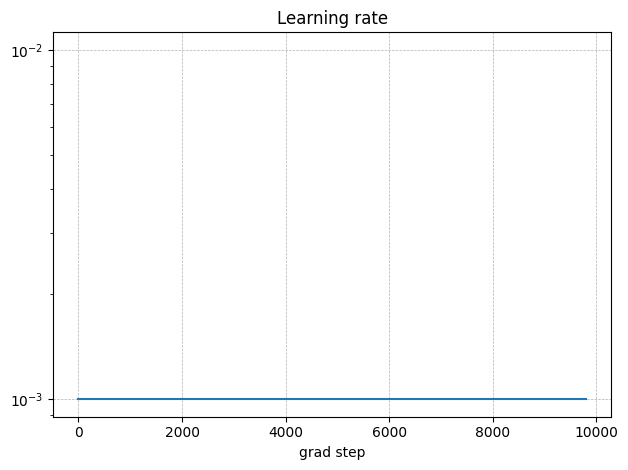

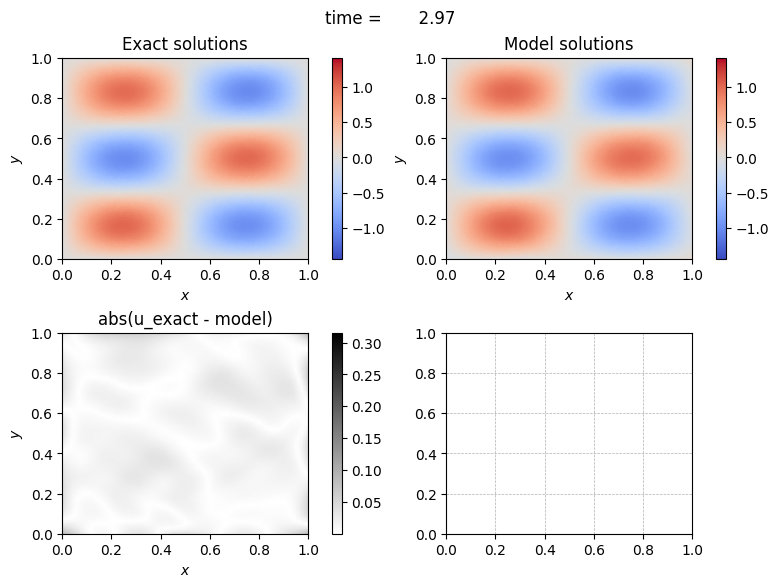

In [5]:
config = replace(
    config_baseline, 
    results_folder=PINNConfig.results_folder / "FFE_full",
    
    use_FFE=True,
    FFE_m=10,
    FFE_sigma=1.0,
    FFE_keep_dims=None)
model_ffe_full = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_ffe_full.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_ffe_full = Trainer(model_ffe_full, optimizer, scheduler, cfg=config)
metrics_ffe_full = trainer_ffe_full.train()

trainer_ffe_full.render_metrics_plots(metrics_ffe_full, save_to_disk=True)

Запуск обучения с частичным FFE для оси X

Render output video: 100%|██████████| 90/90 [05:00<00:00,  3.34s/it]


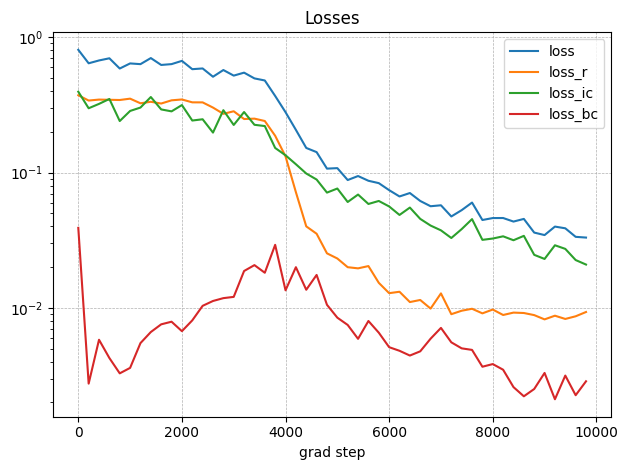

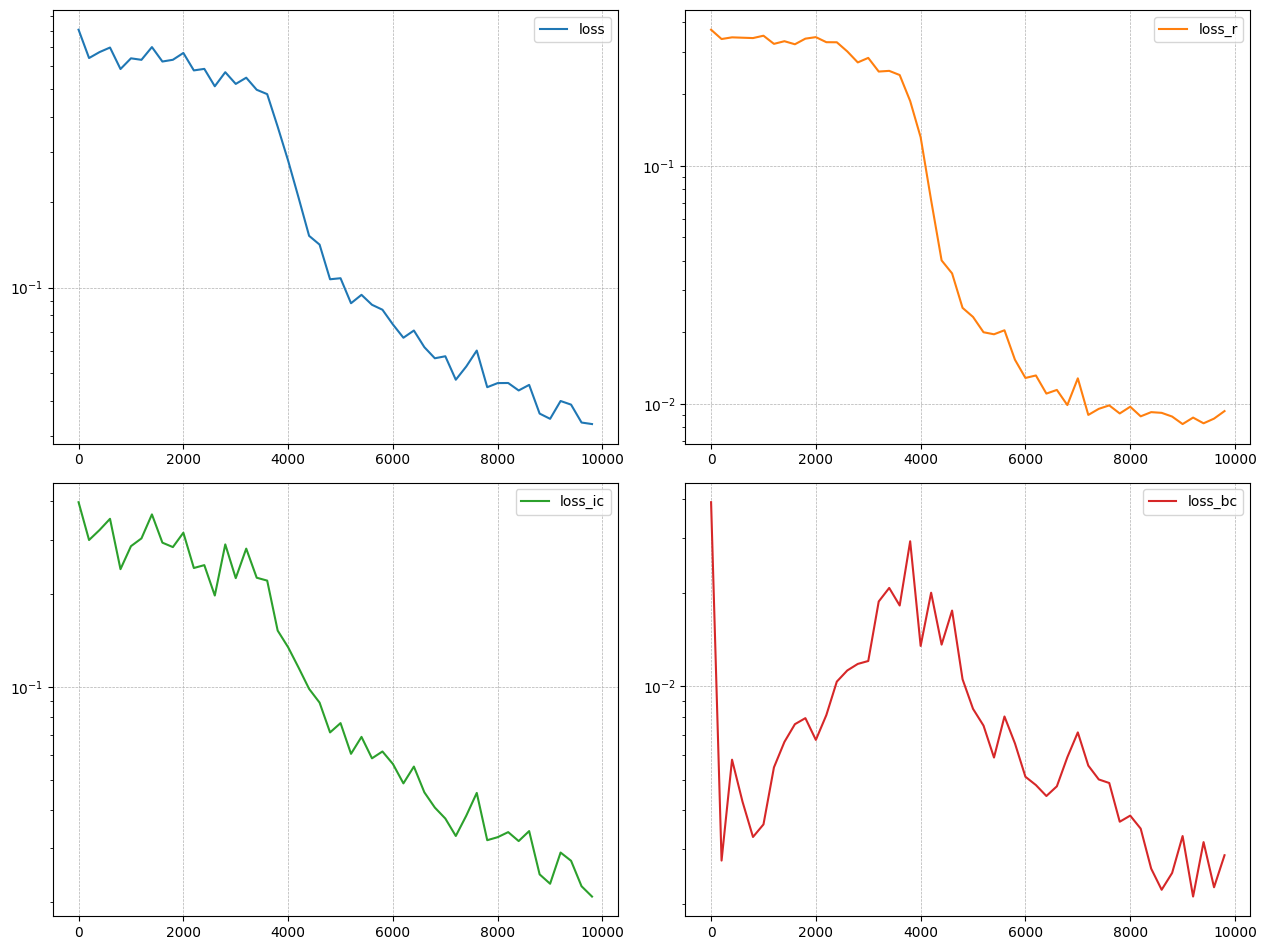

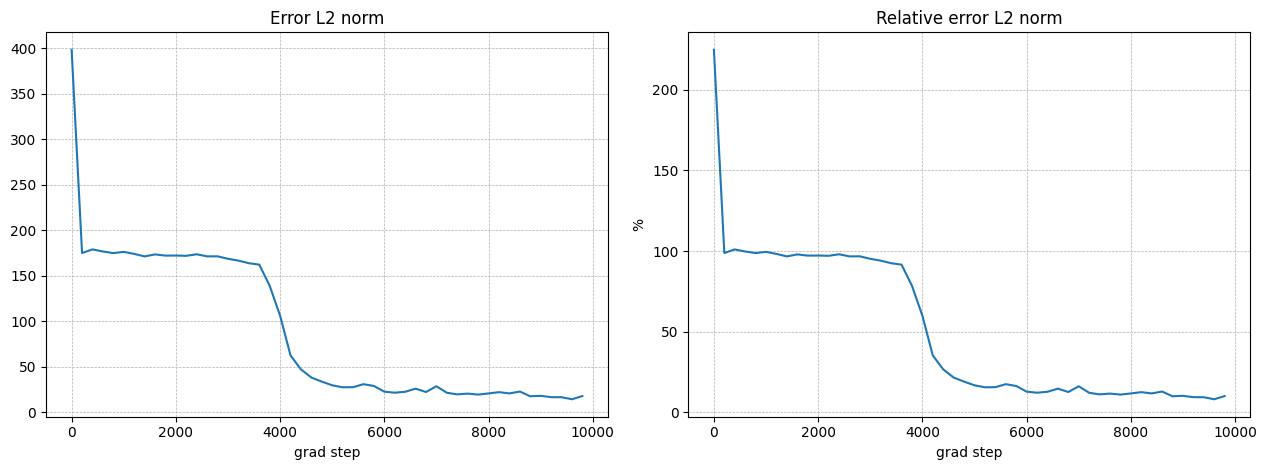

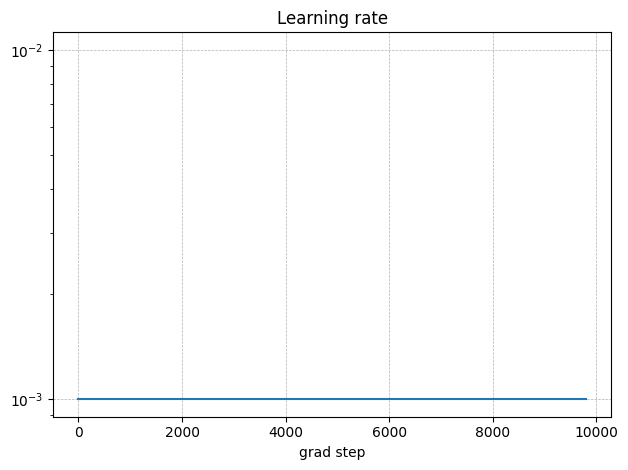

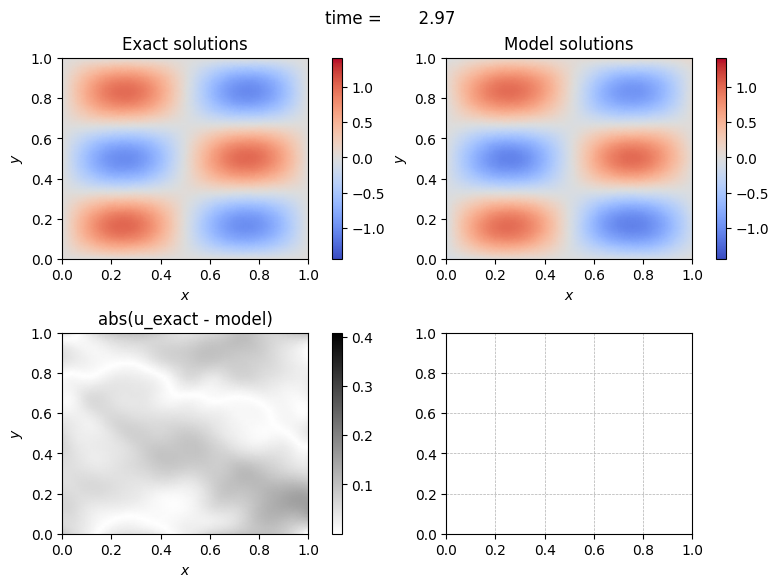

In [6]:
config = replace(
    config_baseline, results_folder=PINNConfig.results_folder / "FFE_partial",
    use_FFE=True,
    FFE_m=10,
    FFE_sigma=1.0,
    FFE_keep_dims=[0, 2])
model_ffe_partial = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_ffe_partial.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_ffe_partial = Trainer(model_ffe_partial, optimizer, scheduler, cfg=config)
metrics_ffe_partial = trainer_ffe_partial.train()

trainer_ffe_partial.render_metrics_plots(metrics_ffe_partial, save_to_disk=True)

Запуск обучения с балансировкой членов loss-функции

Render output video: 100%|██████████| 90/90 [04:46<00:00,  3.19s/it]


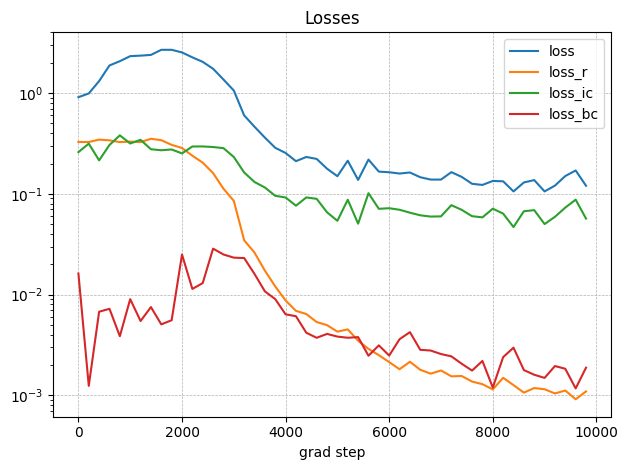

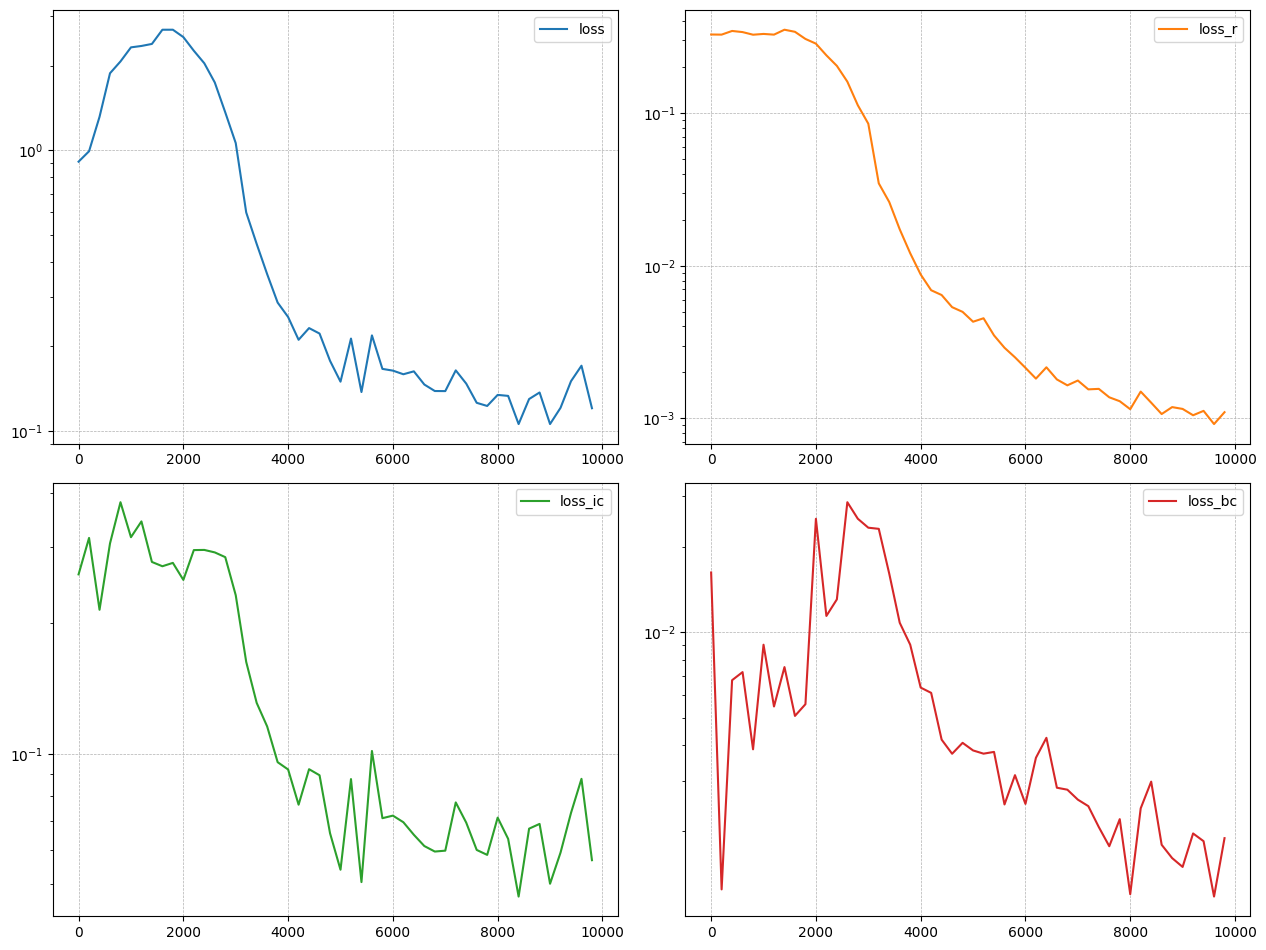

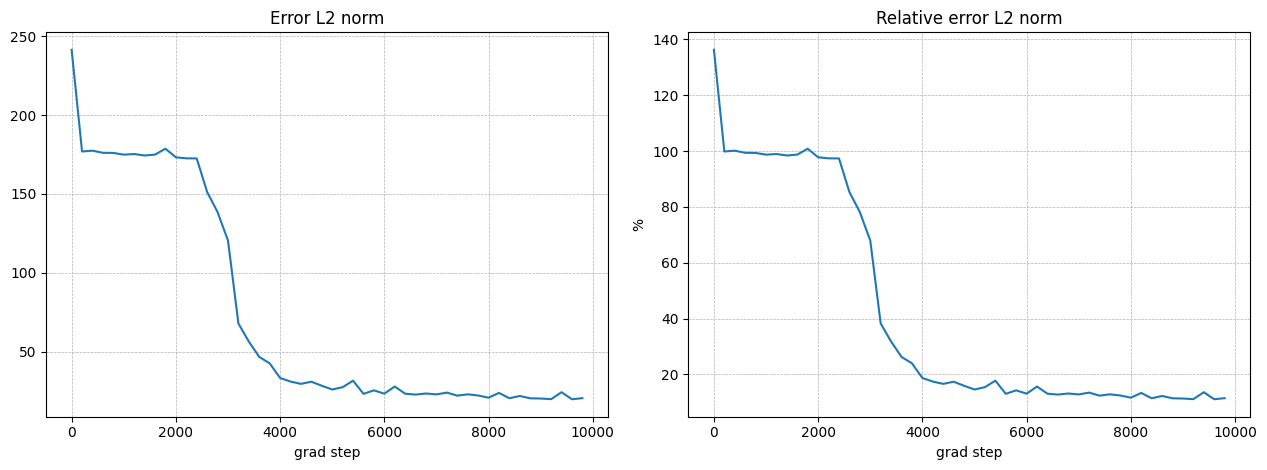

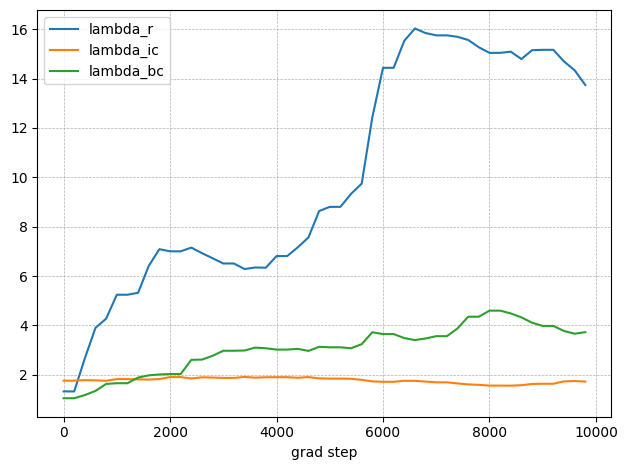

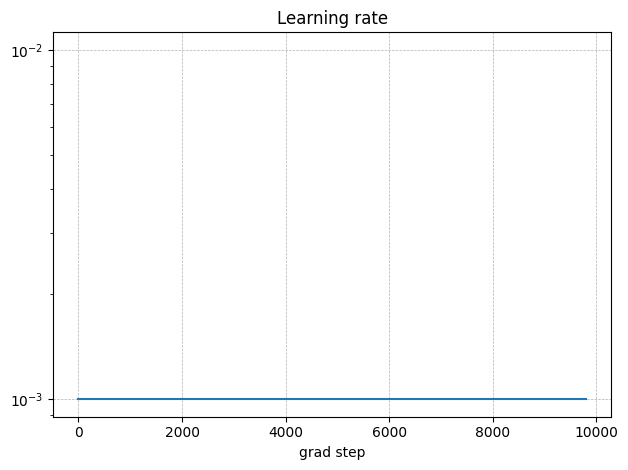

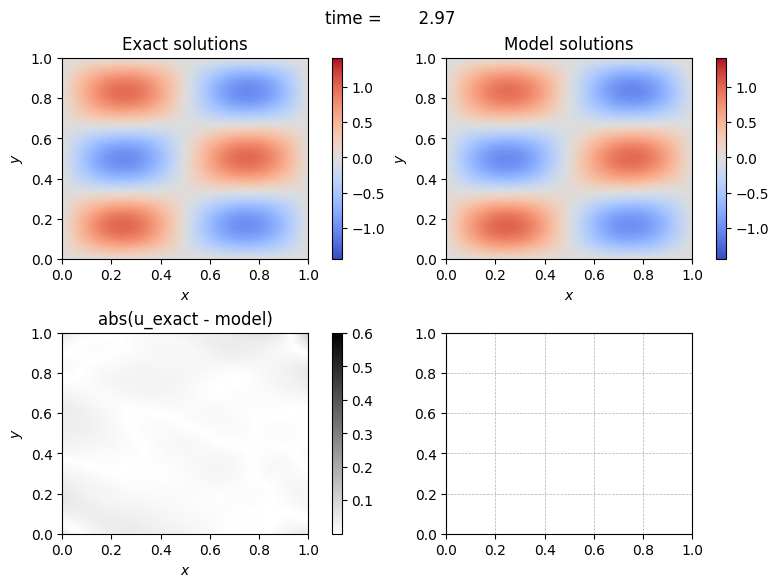

In [7]:
config = replace(
    config_baseline, 
    results_folder=PINNConfig.results_folder / "loss_balancing",
    
    use_grad_norm_weighting=True,
    grad_norm_weighting_alpha=0.9,
    grad_norm_weighting_freq=250)
model_balancing = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_balancing.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_balancing = Trainer(model_balancing, optimizer, scheduler, cfg=config)
metrics_balancing = trainer_balancing.train()

trainer_balancing.render_metrics_plots(metrics_balancing, save_to_disk=True)

Запуск обучения с алгоритмом causal

Render output video: 100%|██████████| 90/90 [04:49<00:00,  3.21s/it]


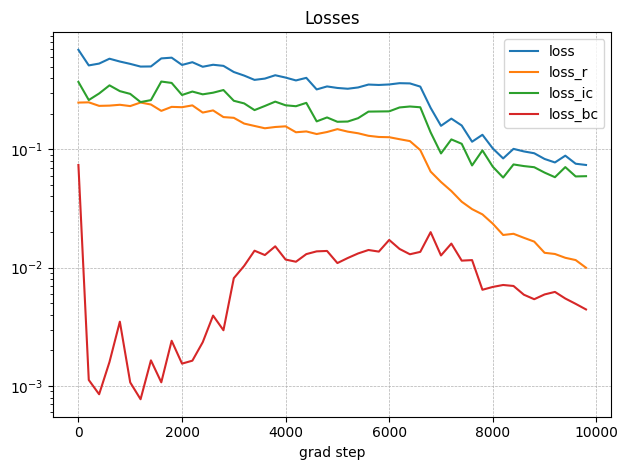

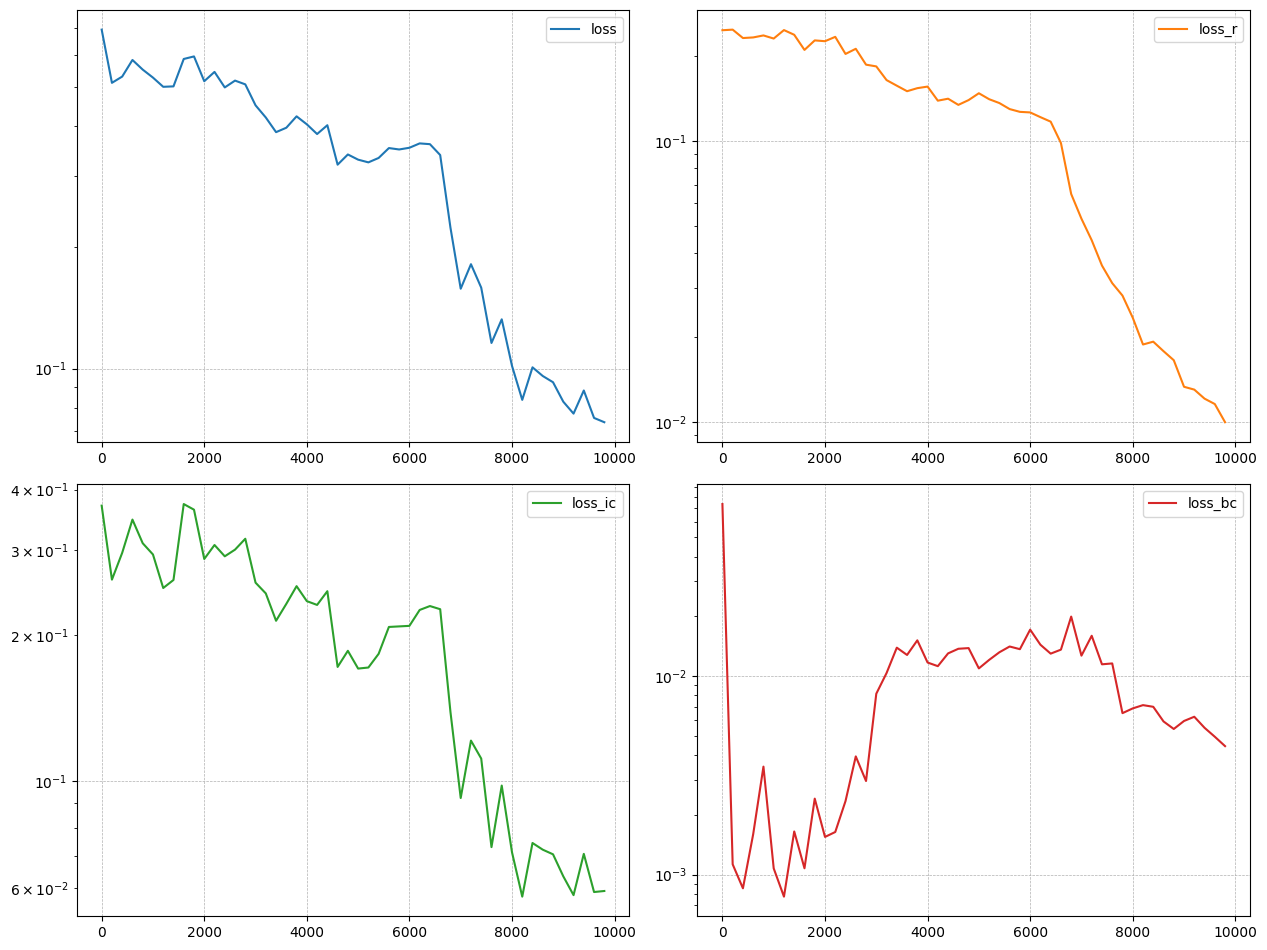

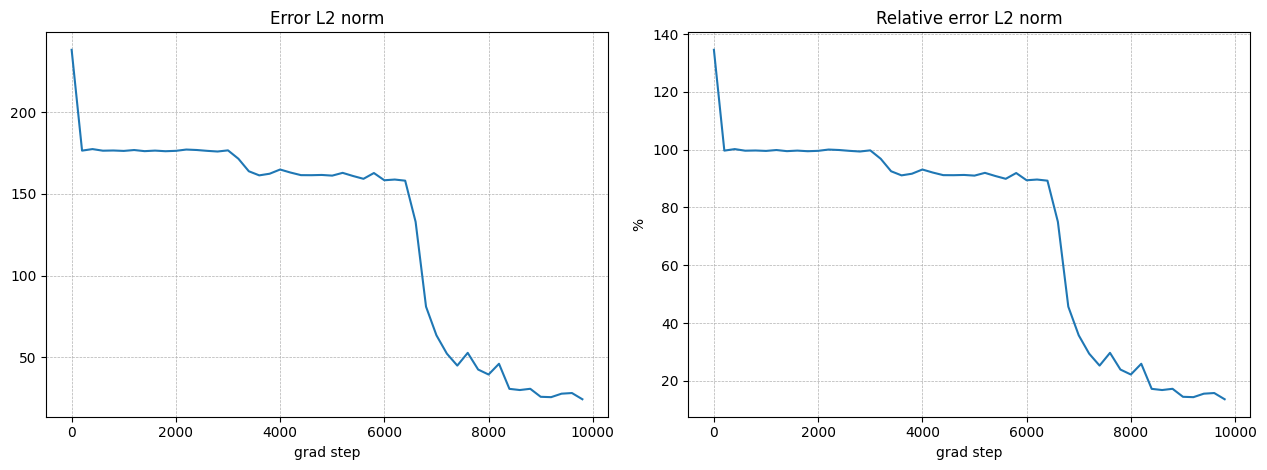

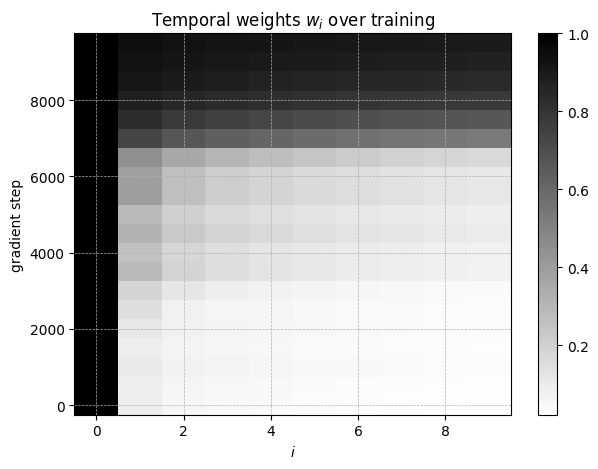

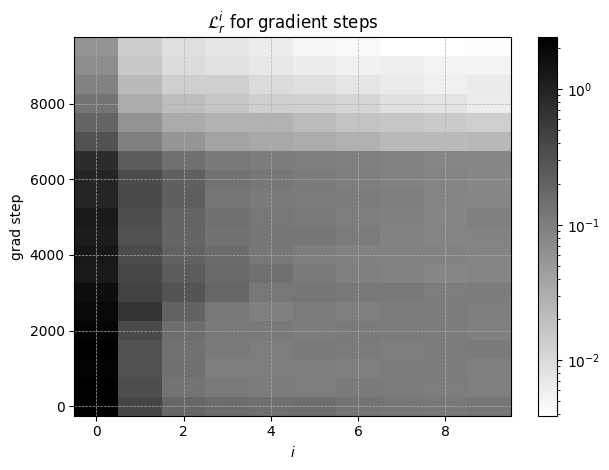

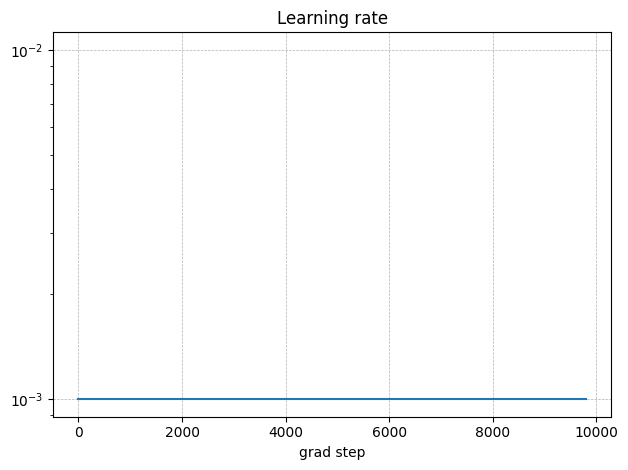

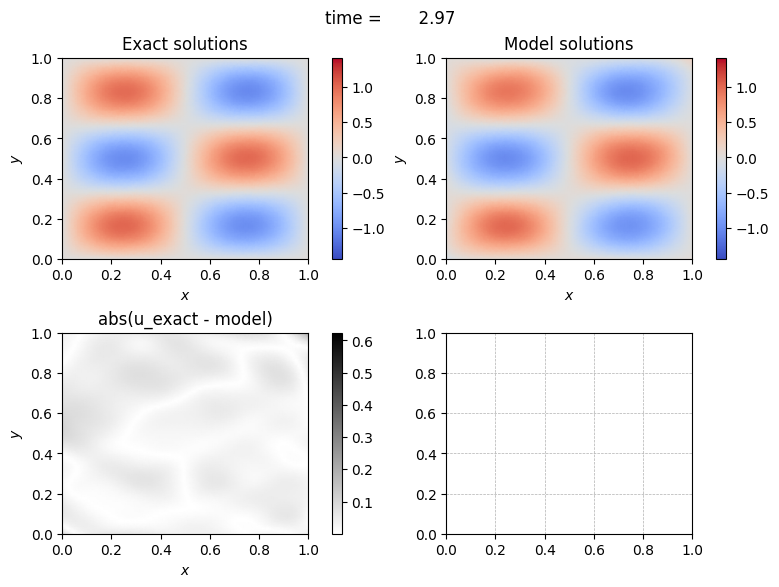

In [8]:
config = replace(
    config_baseline, 
    results_folder=PINNConfig.results_folder / "causal",
    
    use_causal_weighting_scheme=True,
    causal_m=10,
    causal_eps=1.0,
    W_logging_freq=500
    )
model_causal = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_causal.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_causal = Trainer(model_causal, optimizer, scheduler, cfg=config)
metrics_causal = trainer_causal.train()

trainer_causal.render_metrics_plots(metrics_causal, save_to_disk=True)

Сравнение

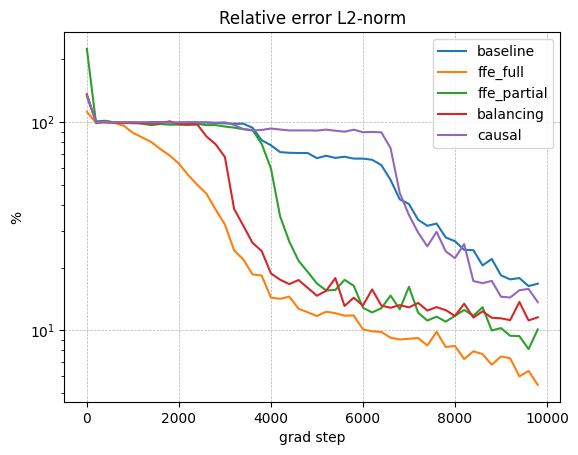

In [9]:
fig, ax = plt.subplots()
ax.semilogy(metrics_baseline['step'], metrics_baseline['rel_err_l2'], label='baseline')
ax.semilogy(metrics_ffe_full['step'], metrics_ffe_full['rel_err_l2'], label='ffe_full')
ax.semilogy(metrics_ffe_partial['step'], metrics_ffe_partial['rel_err_l2'], label='ffe_partial')
ax.semilogy(metrics_balancing['step'], metrics_balancing['rel_err_l2'], label='balancing')
ax.semilogy(metrics_causal['step'], metrics_causal['rel_err_l2'], label='causal')
ax.set(title="Relative error L2-norm", xlabel="grad step", ylabel="%")
ax.legend()
plt.show()
fig.savefig(PINNConfig.results_folder / "total_rel_err_l2_norm.png", dpi=300)